# Databased used
- CREMA-D: 7,442 clips
- RAVDESS: 2,880 clips
- TESS: 5,600 clips
- SAVEE: 480 clips

This provides a total of **16,402** inputs overall, with 7 emotions (anger, disgust, fear, happy, neutral, sad, suprise).

In [1]:
# Import libraries
# KERNEL SETUP IN VS CODE:
# conda create -n myenv python=3.12.2
# conda activate myenv

%pip install resampy tf_keras tensorflow librosa pandas matplotlib kagglehub seaborn

import IPython.display as ipd
from IPython.display import Audio
import kagglehub
import librosa
from librosa import feature
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Datasets via kagglehub

cremad = kagglehub.dataset_download("ejlok1/cremad")
print("CREMA-D to dataset files:", cremad)

ravdess = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("RAVDESS to dataset files:", ravdess)

tess = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("RAVDESS to dataset files:", tess)

savee = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("RAVDESS to dataset files:", savee)

CREMA-D to dataset files: C:\Users\eskillman\.cache\kagglehub\datasets\ejlok1\cremad\versions\1
RAVDESS to dataset files: C:\Users\eskillman\.cache\kagglehub\datasets\uwrfkaggler\ravdess-emotional-speech-audio\versions\1
RAVDESS to dataset files: C:\Users\eskillman\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1
RAVDESS to dataset files: C:\Users\eskillman\.cache\kagglehub\datasets\ejlok1\surrey-audiovisual-expressed-emotion-savee\versions\1


# Pre-processing
## CREMA-D

In [3]:
# Load CREMA-D Dataset
paths = []
emotions = []

for dirname, _, filenames in os.walk(cremad): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
cremad_df = pd.DataFrame()
cremad_df['paths'] = paths
cremad_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

cremad_df['emotions'] = cremad_df['emotions'].map(emotion_map)

print(cremad_df.head())

print(cremad_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV\\1001_DFA_ANG_XX.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV\\1001_DFA_DIS_XX.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV\\1001_DFA_FEA_XX.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV\\1001_DFA_HAP_XX.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV\\1001_DFA_NEU_XX.wav']
['ANG', 'DIS', 'FEA', 'HAP', 'NEU']
                                               paths emotions
0  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
1  C:\Users\eskillman\.cache\kagglehub\datasets\e...  disgust
2  C:\Users\eskillman\.cache\kagglehub\datasets\e...     fear
3  C:\Users\eskillman\.cache\kagglehub\datasets\e...    happy
4  C:\Users\eskillman\.cache\kagglehub\datasets\e...  neutral
emotions
anger      1271
d

## RAVEDESS

In [4]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(ravdess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('.')[0].split('-')  # Get the emotion number (e.g., '03' = happy)
            emotions.append(int(part[2]))


print(paths[:5])
print(emotions[:5])

# Create DataFrame
ravdess_df = pd.DataFrame()
ravdess_df['paths'] = paths
ravdess_df['emotions'] = emotions


# Map emotion codes to full emotions
emotion_map = {
    1 : 'neutral',
    2 : 'neutral', # calm as neutral to balance dataset
    3 : 'happy',
    4 : 'sad',
    5 : 'anger',
    6 : 'fear',
    7 : 'disgust',
    8 : 'suprise'

}

ravdess_df['emotions'] = ravdess_df['emotions'].map(emotion_map)

print(ravdess_df.head())

print(ravdess_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-01-01-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-01-02-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-02-01-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-01-01-02-02-01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\Actor_01\\03-01-02-01-01-01-01.wav']
[1, 1, 1, 1, 2]
                                               paths emotions
0  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral
1  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral
2  C:\Users\eskillman\.cache\kagglehub\datasets\u...  neutral


## TESS

In [5]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(tess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('.')[0].split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
tess_df = pd.DataFrame()
tess_df['paths'] = paths
tess_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'angry': 'anger',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'ps' : 'suprise',
    'sad' : 'sad'
}

tess_df['emotions'] = tess_df['emotions'].map(emotion_map)

print(tess_df.head())

print(tess_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']
['angry', 'angry', 'angry', 'angry', 'angry']
                                               paths e

## SAVEE

In [6]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(savee): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('_')[1]  # Get the emotion code (e.g., 'ANG')
            emotion = part[:-6]
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
savee_df = pd.DataFrame()
savee_df['paths'] = paths
savee_df['emotions'] = emotions

emotion_map = {
    'n': 'neutral',
    'd': 'disgust',
    'a': 'anger',
    'f': 'fear',
    'h': 'happy',
    'sa': 'sad',
    'su' : 'suprise'
}

savee_df['emotions'] = savee_df['emotions'].map(emotion_map)

print(savee_df.head())

print(savee_df['emotions'].value_counts())

['C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a01.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a02.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a03.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a04.wav', 'C:\\Users\\eskillman\\.cache\\kagglehub\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL\\DC_a05.wav']
['a', 'a', 'a', 'a', 'a']
                                               paths emotions
0  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
1  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
2  C:\Users\eskillman\.cache\kagglehub\datasets\e...    anger
3  C:\Users\eskillman\.cache\kagglehub\datasets\e.

# Integration

In [7]:
emotion_data = pd.concat([cremad_df, ravdess_df, tess_df, savee_df], axis = 0)

emotion_data.to_csv("emotion_data.csv", index=False)

print(emotion_data.emotions.value_counts())

emotions
neutral    2583
anger      2515
disgust    2515
fear       2515
happy      2515
sad        2515
suprise    1244
Name: count, dtype: int64


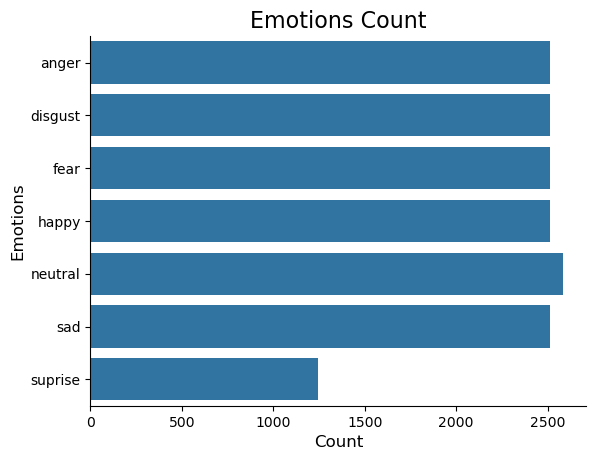

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Emotions Count', size=16)
sns.countplot(emotion_data.emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data Visualition

## Load

In [9]:
data, sr = librosa.load(paths[0], sr=None) #Latest path value from SAVEE (angry)
print(emotions[0])
ipd.Audio(data,rate=sr)

c:\ProgramData\Anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


a


## Mel Spectogram

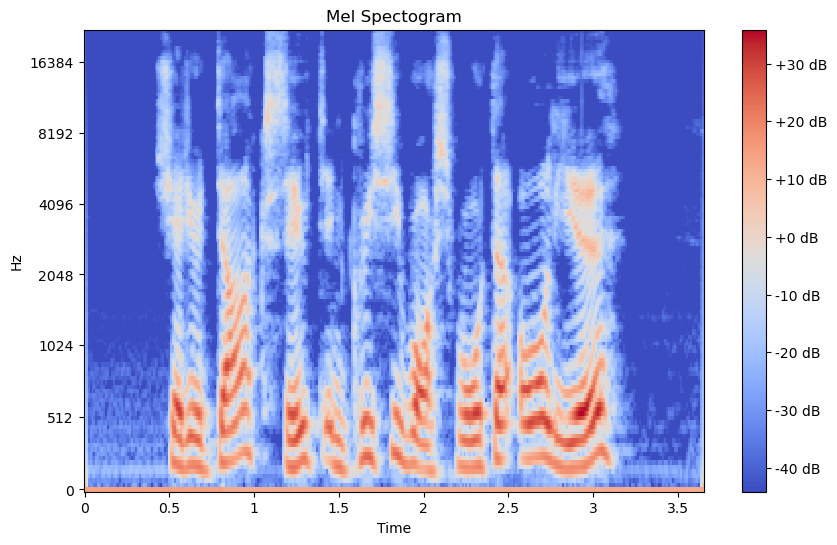

In [10]:
n_mels = 128
n_fft = 2048
hop_length = 512
fmax = 8000
mel_spectogram = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

log_mel_spectogram = librosa.power_to_db(mel_spectogram)

plt.figure(figsize=(10, 6))
librosa.display.specshow(log_mel_spectogram, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectogram')
plt.show()

## MFCC

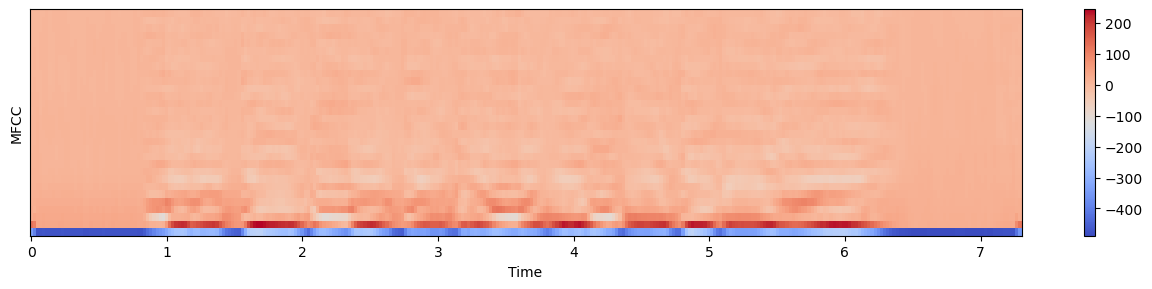

In [11]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

# Data Augmentation

In [12]:
# Time Stretching
def stretch(audio, rate=0.8):
    return librosa.effects.time_stretch(audio, rate=0.8)

# Pitch Shifting
def pitch(audio, sr):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=2)

# Add Noise
def noise(audio, noise_level=0.005):
    noise_amp = noise_level * np.amax(audio)
    noise_array = noise_amp * np.random.normal(0, 1, len(audio))
    audio_with_noise = audio + noise_array
    return audio_with_noise

# Shifting (Time warping)
def shift(audio):
    return np.roll(audio, shift=int(sr * 0.2))


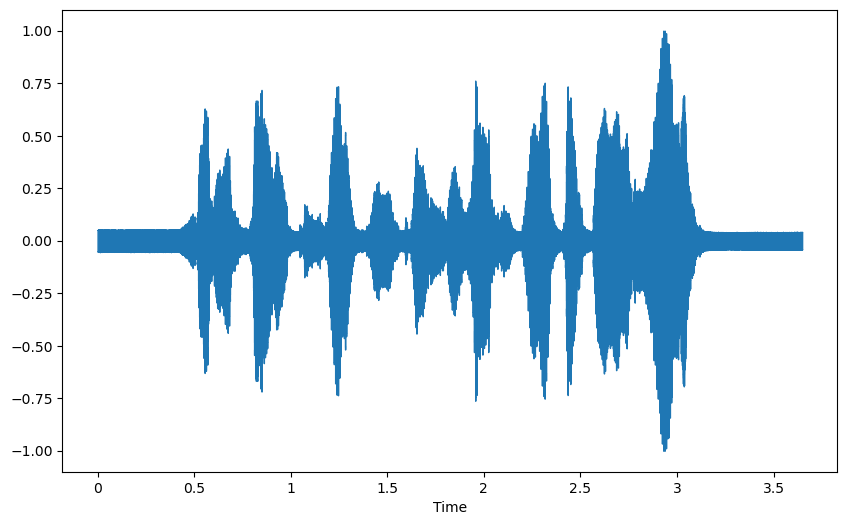

In [13]:
# Normal
import librosa.display
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

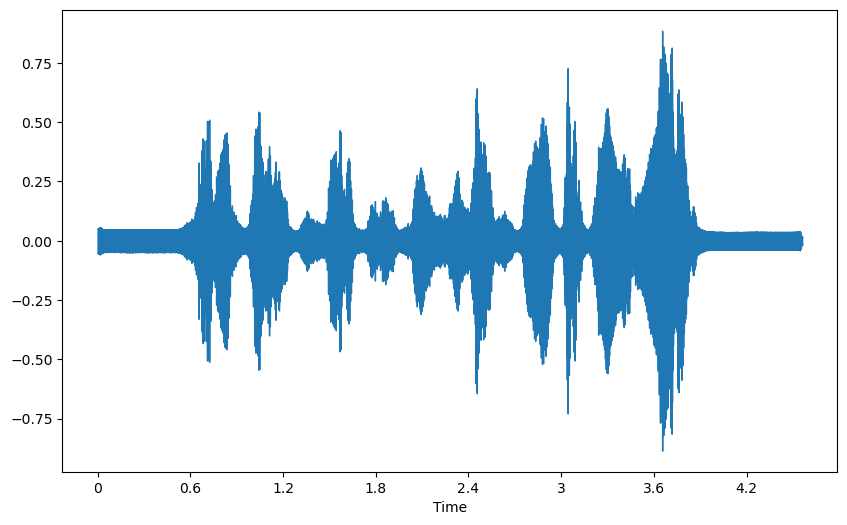

In [14]:
# Time Stretching
x = stretch(data)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

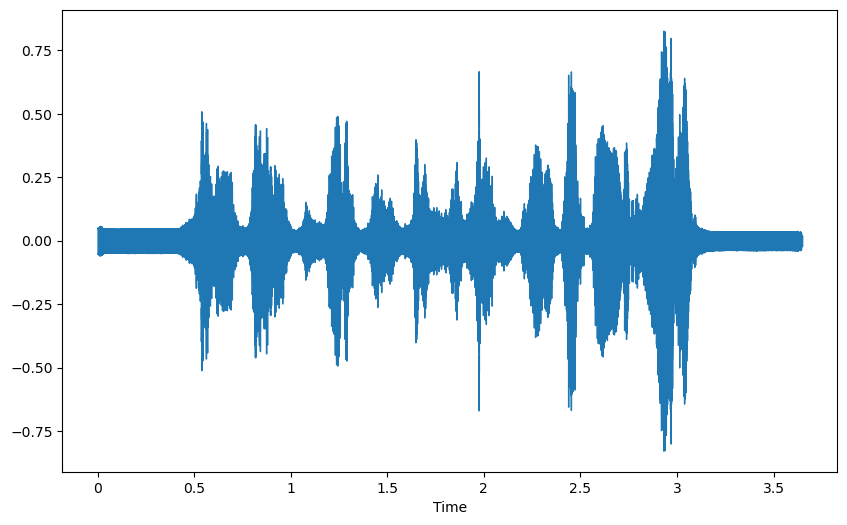

In [15]:
# Pitch Shifting
x = pitch(data, sr)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

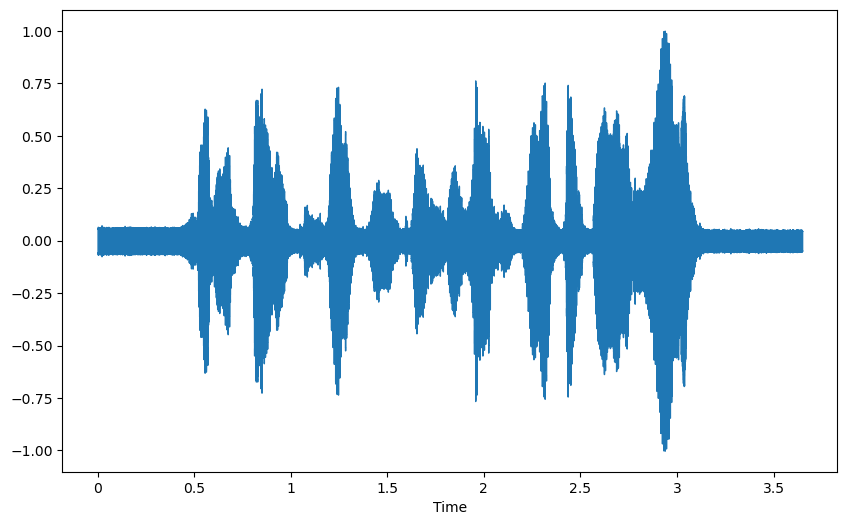

In [16]:
# Add Noise
x = noise(data)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

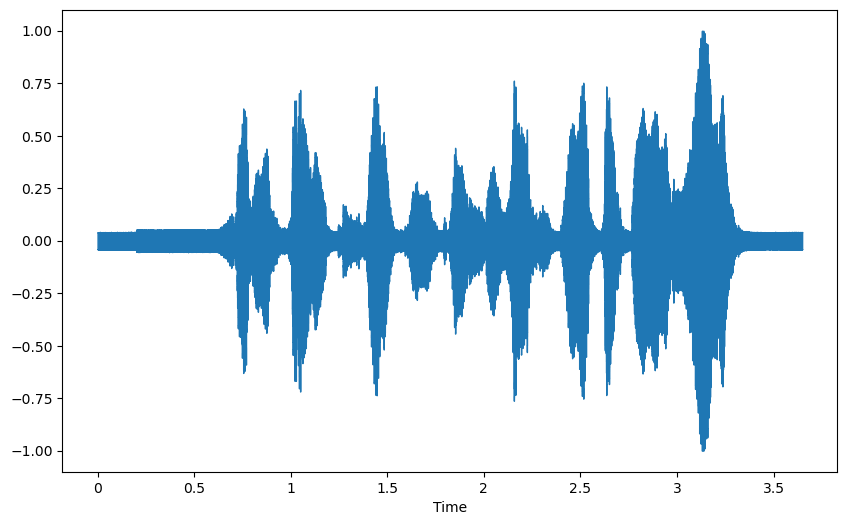

In [17]:
# Shifting (Time warping)
x = shift(data)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature Extraction

In [18]:
n_mels = 128
n_fft = 2048
hop_length = 512
fmax = 8000

def mel_spectogram(data, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max) # =np.max normalised relative to the most intense value
    return log_mel_spec


In [19]:
def get_features(path,duration=2.5, offset=0.6):
    data, sr =librosa.load(path,duration=duration,offset=offset)

    features = []

    aud=mel_spectogram(data, sr)
    features.append(aud)

    pitched_aud = pitch(data, sr)
    pitch_ms = mel_spectogram(pitched_aud, sr)
    features.append(pitch_ms)

    noised_aud = noise(data)
    noise_ms = mel_spectogram(noised_aud, sr)
    features.append(noise_ms)

    shifted_aud = shift(data)
    shift_ms = mel_spectogram(shifted_aud, sr)
    features.append(shift_ms)

    pitched_audN = pitched_aud
    pitch_noise_aud = noise(pitched_audN)
    pitch_noise_mc = mel_spectogram(pitch_noise_aud, sr)
    features.append(pitch_noise_mc)

    features = np.array([spec[..., np.newaxis] for spec in features])

    return features

In [20]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [21]:
""" # WITHOUT PARRELL WAY 
from tensorflow.keras.utils import to_categorical 
import timeit
from tqdm import tqdm


start = timeit.default_timer()

X, Y=[],[]

for path, emotion, index in tqdm (zip(emotion_data.paths, emotion_data.emotions, range(emotion_data.paths.shape[0]))):
    if index%500==0:
        print(f'{index} audio has been processed')

    features=get_features(path)

    for feature in features:

        feature = feature[..., np.newaxis]

        X.append(feature)
        Y.append(emotion)

print('Done')

stop = timeit.default_timer()

print('Time: ', stop - start)

X = np.array(X)
Y = np.array(Y)

print(X.head())
print(Y.head()) """

" # WITHOUT PARRELL WAY \nfrom tensorflow.keras.utils import to_categorical \nimport timeit\nfrom tqdm import tqdm\n\n\nstart = timeit.default_timer()\n\nX, Y=[],[]\n\nfor path, emotion, index in tqdm (zip(emotion_data.paths, emotion_data.emotions, range(emotion_data.paths.shape[0]))):\n    if index%500==0:\n        print(f'{index} audio has been processed')\n\n    features=get_features(path)\n\n    for feature in features:\n\n        feature = feature[..., np.newaxis]\n\n        X.append(feature)\n        Y.append(emotion)\n\nprint('Done')\n\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)\n\nX = np.array(X)\nY = np.array(Y)\n\nprint(X.head())\nprint(Y.head()) "

In [22]:
from joblib import Parallel, delayed
import timeit
import numpy as np
import librosa.util
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

scaler = StandardScaler()

def tqdm_parallel(iterable, total):
    for item in tqdm(iterable, total=total, desc="Processing Audio Files"):
        yield item


# Function to extract and process features
def process_feature(path, emotion, max_shape=(128, 128)):  
    features = get_features(path)  
    X = []  
    Y = []  

    for feature in features:
        # Fix length of mel
        feature = librosa.util.fix_length(feature, size=max_shape[0], axis=0)
        feature = librosa.util.fix_length(feature, size=max_shape[1], axis=1)

        # Reshape the feature to 2D (flatten it), standardise it, and then reshape it back
        feature_reshaped = feature.reshape(-1, feature.shape[-1])
        feature_standardized = scaler.fit_transform(feature_reshaped) 
        
        feature_standardized = feature_standardized.reshape(feature.shape)  # Reshape it back to original shape

        X.append(feature_standardized)  
        Y.append(emotion)  

    return X, Y

# Load data
paths = emotion_data.paths  
emotions = emotion_data.emotions  
num_files = len(paths)  

start = timeit.default_timer()

# Parallel processing with tqdm
results = Parallel(n_jobs=-1)(
    delayed(process_feature)(path, emotion) for path, emotion in tqdm_parallel(zip(paths, emotions), total=num_files)
)

# Collect results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

# Convert to NumPy arrays
X = np.stack(X, axis=0)
Y = np.array(Y)

stop = timeit.default_timer()
print(f'Time: {stop - start:.2f} seconds')

# One-Hot Encoding
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y) 
Y_one_hot = to_categorical(Y_encoded)  # Convert to one-hot encoding

# Shape verification
assert len(Y) == X.shape[0], "Mismatch: Number of labels does not match the number of samples!"
print(f'Final X shape: {X.shape}')  # Expected (num_samples, 128, 128, 1)
print(f'Final Y shape: {Y_one_hot.shape}')  # Expected (num_samples, num_classes)


Processing Audio Files: 100%|██████████| 16402/16402 [01:49<00:00, 149.41it/s]


Time: 113.57 seconds
Final X shape: (82010, 128, 128, 1)
Final Y shape: (82010, 7)


In [23]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42, shuffle=True)

# Validation split (10% of training data)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

num_classes = Y_one_hot.shape[1]  # Number of emotion categories

model = Sequential([
    # Convolutional feature extraction
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Conv2D(256, (3,3), activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPooling2D((2,2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\eskillman\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,619,655 (17.62 MB)

 Trainable params: 4,617,927 (17.62 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [25]:
"""from tensorflow.keras.applications import EfficientNetB0

# MODEL FROM IMAGENET
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 256, 3))
base_model.trainable = True  # Fine-tune the whole model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()"""

'from tensorflow.keras.applications import EfficientNetB0\n\n# MODEL FROM IMAGENET\nbase_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 256, 3))\nbase_model.trainable = True  # Fine-tune the whole model\n\nmodel = Sequential([\n    base_model,\n    Flatten(),\n    Dense(256, activation=\'relu\'),\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(num_classes, activation=\'softmax\')\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\nmodel.summary()'

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5, verbose=1)

# Train the CNN model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=64,
    callbacks=[model_checkpoint, early_stop, lr_reduction]
)


Epoch 1/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4275 - loss: 1.6983
Epoch 1: val_loss improved from inf to 0.88660, saving model to best_model.keras
923/923 ━━━━━━━━━━━━━━━━━━━━ 349s 375ms/step - accuracy: 0.4276 - loss: 1.6979 - val_accuracy: 0.6651 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 2/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6861 - loss: 0.8385
Epoch 2: val_loss improved from 0.88660 to 0.82572, saving model to best_model.keras
923/923 ━━━━━━━━━━━━━━━━━━━━ 344s 373ms/step - accuracy: 0.6861 - loss: 0.8384 - val_accuracy: 0.6860 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 3/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7583 - loss: 0.6633
Epoch 3: val_loss improved from 0.82572 to 0.67713, saving model to best_model.keras
923/923 ━━━━━━━━━━━━━━━━━━━━ 344s 373ms/step - accuracy: 0.7583 - loss: 0.6633 - val_accuracy: 0.7490 - val_loss: 0.6771 - learning_rate: 0.0010
Epoch 4/50
923/923 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/s

In [27]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Lost: {test_loss:.4f}")


513/513 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9321 - loss: 0.2880
Test Accuracy: 93.26%
Test Lost: 0.2837


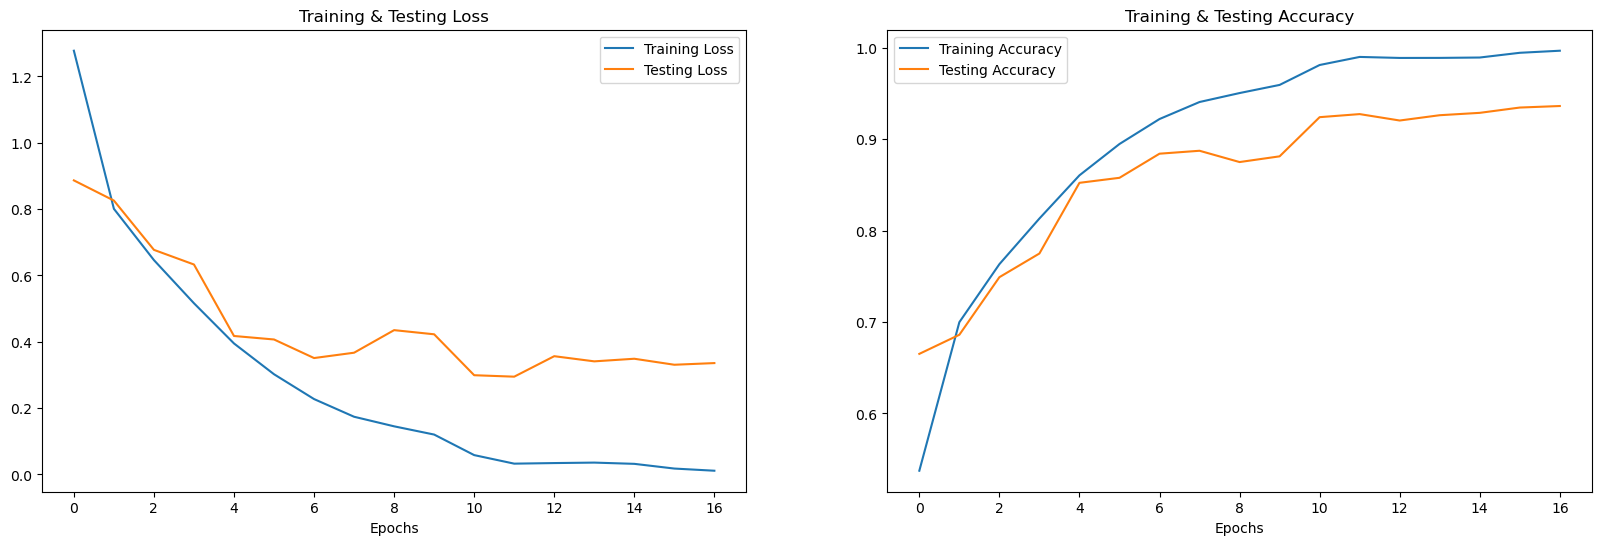

In [28]:
stopped_epoch = early_stop.stopped_epoch

epochs = [i for i in range(stopped_epoch+1)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [29]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
encoder = OneHotEncoder()

# encoder = LabelEncoder()
encoder.fit(Y_train[1])

pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test)

df0 = pd.DataFramge(columns=['Predicted Lables', 'Actual Labels'])#
df0['Predicted Labels'] = y_pred.flatten()
df0['Actual Labels'] = y_test.flatten()

df0.head(10)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 1. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
df0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index = [i for i in encoder.categories_]), columns = [i for i in encoder.categories_]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))